# Object pose estimation

## Overview

In this tutorial, we will showcase how to optimize the pose of an object correctly counting for the visibility discontinuities. We are going to optimize several latent variables that controls the translation and rotation of the object.

In differentiable rendering, we aim to evaluate the derivative of a pixel intensity integral with respect to a scene parameter $\pi$ as follows:
$$
\partial_\pi I(\pi) = \partial_\pi \int_P f(\textbf{x}, \pi) ~ d\textbf{x}
$$
where $\textbf{x}$ is a light path in the path space $P$. When the function $f(\cdot)$ is continuous with $\pi$, we can move the derivative into the integral and then apply Monte Carlo integration. This justifies the correctness of differentiating the entire rendering pipeline with autodiff, as is done in previous tutorials. But when the discontinuities depend on the scene parameter $\pi$, for example the silhouette of an object could move as we translate it, direct autodiff will yield biased results missing a line integral along the discontinuous boundary. We propose a method based on reparameterization that removes the dependency of discontinuities on scene parameters from the integral.

Reparameterizations for differentiable rendering were proposed in:

      "Reparameterizing discontinuous integrands for differentiable rendering"
      (Proceedings of SIGGRAPH Asia'19) by Guillaume Loubet,
      Nicolas Holzschuch, and Wenzel Jakob.
      
<cite data-cite="Loubet2019Reparameterizing">Loubet et al. (2019)</cite>

The specific change of variables used in Mitsuba is described in:

      "Unbiased Warped-Area Sampling for Differentiable Rendering"
      (Procedings of SIGGRAPH'20) by Sai Praveen Bangaru,
      Tzu-Mao Li, and Frédo Durand.
      
<cite data-cite="Bangaru2020">Bangaru et al. (2020)</cite>

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
    
<ul>
  <li>Perform optimization with discontinuity-aware methods</li>
  <li>Optimize latent variables to control the motion of an object</li>
</ul>
    
</div>


## Step 1 - Setup

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Step 2 - Scene construction

In [2]:
integrator = {
    'type': 'prb_reparam', # could be the simpler `direct_reparam` when it is merged
    'reparam_max_depth': 2,
    'max_depth': 2
}

In [27]:
from mitsuba.scalar_rgb import Transform4f as T

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    # sensor
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 60,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    # wall
    'plane': {
        'type': 'obj',
        'filename': '../../scenes/meshes/rectangle.obj',
        'to_world': T.translate([0, 0, -2]) * T.scale(2.0),
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    # object
    'bunny': {
        'type': 'ply',
        'filename': '../../scenes/meshes/bunny.ply',
        'to_world': T.scale(6.5),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
        },
    },
    # light
    'light': {
        'type': 'obj',
        'filename': '../../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]) * T.scale(0.25)
    }
})

2022-03-30 13:03:22 INFO main [Scene] Embree ready. (took 16ms)

## Step 3 - Create a reference scene

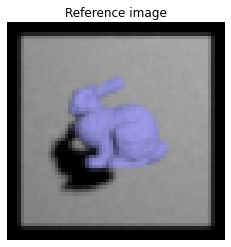

In [29]:
img_ref = mi.render(scene, seed=0, spp=1024)

from matplotlib import pyplot as plt
plt.imshow(mi.util.convert_to_bitmap(img_ref)); plt.axis('off'); plt.title('Reference image');

## Step 4 - Optimization

In [30]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])

In [31]:
def apply_transformation(params, opt):
    opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    opt['angle'] = dr.clamp(opt['angle'], -0.5, 0.5)
    
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0]) * \
            mi.Transform4f.rotate([0, 1, 0], opt['angle'] * 100.0)
    
    params['bunny.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

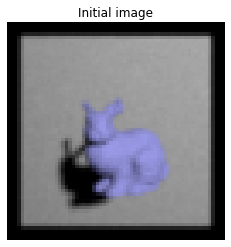

In [32]:
opt = mi.ad.Adam(lr=0.025, params=params)
opt['angle'] = mi.Float(0.25)
opt['trans'] = mi.Point2f(0.1, -0.25)

apply_transformation(params, opt)

opt.update()

img_init = mi.render(scene, seed=0, spp=1024)

plt.imshow(mi.util.convert_to_bitmap(img_init)); plt.axis('off'); plt.title('Initial image');

In [33]:
loss_hist = []
for it in range(50):
    apply_transformation(params, opt)
    
    img = mi.render(scene, params, seed=it, spp=16)
    
    loss = dr.hsum_async(dr.sqr(img - img_ref)) / len(img)
    
    dr.backward(loss)

    opt.step()
    
    opt.update()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle={opt['angle'][0]:.4f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]")

Iteration 00: error=0.008431, angle=0.2250, trans=[0.0750, -0.2250]
Iteration 01: error=0.008551, angle=0.2005, trans=[0.0501, -0.2018]
Iteration 02: error=0.008272, angle=0.1797, trans=[0.0327, -0.1782]
Iteration 03: error=0.007940, angle=0.1610, trans=[0.0223, -0.1541]
Iteration 04: error=0.007738, angle=0.1521, trans=[0.0261, -0.1296]
Iteration 05: error=0.007360, angle=0.1419, trans=[0.0292, -0.1048]
Iteration 06: error=0.007034, angle=0.1318, trans=[0.0277, -0.0808]
Iteration 07: error=0.006037, angle=0.1168, trans=[0.0236, -0.0563]
Iteration 08: error=0.005216, angle=0.1030, trans=[0.0159, -0.0316]
Iteration 09: error=0.003805, angle=0.0859, trans=[0.0036, -0.0065]
Iteration 10: error=0.002924, angle=0.0682, trans=[-0.0100, 0.0179]
Iteration 11: error=0.003012, angle=0.0484, trans=[-0.0254, 0.0348]
Iteration 12: error=0.003826, angle=0.0295, trans=[-0.0301, 0.0440]
Iteration 13: error=0.004241, angle=0.0113, trans=[-0.0278, 0.0445]
Iteration 14: error=0.004367, angle=-0.0031, tra

## Step 5 - Visualize the results

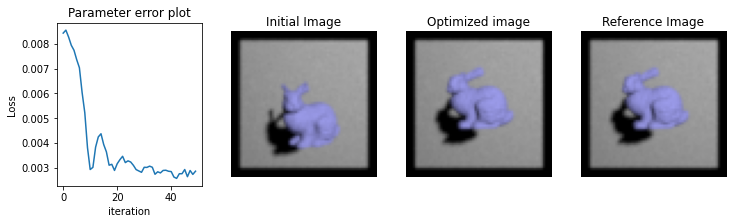

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].plot(loss_hist)
axs[0].set_xlabel('iteration'); 
axs[0].set_ylabel('Loss'); 
axs[0].set_title('Parameter error plot');

axs[1].imshow(mi.util.convert_to_bitmap(img_init))
axs[1].axis('off')
axs[1].set_title('Initial Image')

axs[2].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[2].axis('off')
axs[2].set_title('Optimized image')

axs[3].imshow(mi.util.convert_to_bitmap(img_ref))
axs[3].axis('off')
axs[3].set_title('Reference Image');

<div class="admonition note alert alert-block alert-info">

📑 **See also**
    
<ul>
  <li><a href="url"><tt>mitsuba.load_dict</tt></a></li>
</ul>
    
</div>